### Rice Leaf Disease Analyzer


<img src="http://rice.test.woza.work/assets/rice_kaggle.jpg" width="500"></img>


In [1]:
# Check the tensorflow version

import tensorflow as tf
tf.__version__

'2.1.0'

In [2]:
import pandas as pd
import numpy as np
import os

import cv2

import albumentations as albu
from albumentations import Compose, ShiftScaleRotate, Resize
from albumentations.pytorch import ToTensor


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report

import shutil

import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3


In [4]:
os.listdir('../input/rice-leaf-diseases/rice_leaf_diseases')

['Brown spot', 'Bacterial leaf blight', 'Leaf smut']

## Helper Functions

In [5]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




## Prepare the Data

### Create a dataframe containing all the images

In [6]:
leaf_smut_list = \
os.listdir('../input/rice-leaf-diseases/rice_leaf_diseases/Leaf smut')
brown_spot_list = \
os.listdir('../input/rice-leaf-diseases/rice_leaf_diseases/Brown spot')
bacterial_leaf_blight_list = \
os.listdir('../input/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight')

print(len(leaf_smut_list))
print(len(brown_spot_list))
print(len(bacterial_leaf_blight_list))

40
40
40


In [7]:
# Create the train and val sets

df_leaf_smut = pd.DataFrame(leaf_smut_list, columns=['image'])
df_leaf_smut['target'] = 'leaf_smut'

df_brown_spot = pd.DataFrame(brown_spot_list, columns=['image'])
df_brown_spot['target'] = 'brown_spot'

df_bacterial_leaf_blight = pd.DataFrame(bacterial_leaf_blight_list, columns=['image'])
df_bacterial_leaf_blight['target'] = 'bacterial_leaf_blight'


# Create a val set for each class

# Sample 5 validation images from each class
df_leaf_smut_val = df_leaf_smut.sample(n=5, random_state=101)
df_brown_spot_val = df_brown_spot.sample(n=5, random_state=101)
df_bacterial_leaf_blight_val = df_bacterial_leaf_blight.sample(n=5, random_state=101)


print(len(df_leaf_smut_val))
print(len(df_brown_spot_val))
print(len(df_bacterial_leaf_blight_val))

5
5
5


In [8]:
# Create the train set for each class

# leaf_smut
# get a list of val images
val_list = list(df_leaf_smut_val['image'])
# filter out the val images
df_leaf_smut_train = df_leaf_smut[~df_leaf_smut['image'].isin(val_list)] # ~ means notin

# brown_spot
# get a list of val images
val_list = list(df_brown_spot_val['image'])
# filter out the val images
df_brown_spot_train = df_brown_spot[~df_brown_spot['image'].isin(val_list)] # ~ means notin

# bacterial_leaf_blight
# get a list of val images
val_list = list(df_bacterial_leaf_blight_val['image'])
# filter out the val images
df_bacterial_leaf_blight_train = \
df_bacterial_leaf_blight[~df_bacterial_leaf_blight['image'].isin(val_list)] # ~ means notin



print(len(df_leaf_smut_train))
print(len(df_brown_spot_train))
print(len(df_bacterial_leaf_blight_train))

35
35
35


In [9]:
# Create df_data, df_train and df_val

df_data = pd.concat([df_leaf_smut, df_brown_spot, df_bacterial_leaf_blight], axis=0).reset_index(drop=True)

df_train = \
pd.concat([df_leaf_smut_train, df_brown_spot_train, df_bacterial_leaf_blight_train], axis=0).reset_index(drop=True)

df_val = \
pd.concat([df_leaf_smut_val, df_brown_spot_val, df_bacterial_leaf_blight_val], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)
df_train = shuffle(df_train)
df_val = shuffle(df_val)

print(df_data.shape)
print(df_train.shape)
print(df_val.shape)

(120, 2)
(105, 2)
(15, 2)


In [10]:
df_data['target'].value_counts()

leaf_smut                40
bacterial_leaf_blight    40
brown_spot               40
Name: target, dtype: int64

In [11]:
df_train['target'].value_counts()

leaf_smut                35
bacterial_leaf_blight    35
brown_spot               35
Name: target, dtype: int64

In [12]:
df_val['target'].value_counts()

leaf_smut                5
brown_spot               5
bacterial_leaf_blight    5
Name: target, dtype: int64

### Transform the target 

Here we will one hot encode the target classes.

In [13]:
# Create the target as index values

# combine val, train and test
val_len = len(df_val)
train_len = len(df_train)
df_combined =  pd.concat(objs=[df_val, df_train], axis=0).reset_index(drop=True)

# create the dummy variables
df_combined = pd.get_dummies(df_combined, columns=['target'])

# separate the train and val sets
df_val = df_combined[:val_len]
df_train = df_combined[val_len:]


print(df_train.shape)
print(df_val.shape)

(105, 4)
(15, 4)


In [14]:
df_combined.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
0,DSC_0118.jpg,0,1,0
1,DSC_0304.JPG,0,1,0
2,DSC_0365.JPG,1,0,0
3,DSC_0308.JPG,0,0,1
4,DSC_0384.JPG,1,0,0


In [15]:
df_train.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
15,DSC_0339.jpg,0,0,1
16,DSC_0104.jpg,0,1,0
17,DSC_0388.JPG,1,0,0
18,DSC_0500.jpg,0,0,1
19,DSC_0312.JPG,0,0,1


In [16]:
df_val.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
0,DSC_0118.jpg,0,1,0
1,DSC_0304.JPG,0,1,0
2,DSC_0365.JPG,1,0,0
3,DSC_0308.JPG,0,0,1
4,DSC_0384.JPG,1,0,0


## Save the dataframes as compressed csv files
These csv files will allow us to use Pandas chunking to feed images into the generators.

In [17]:
df_combined.to_csv('df_combined.csv.gz', compression='gzip', index=False)

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)


In [18]:
!ls

df_combined.csv.gz  df_train.csv.gz  df_val.csv.gz


### Move all images to the same folder

In [19]:
# Create a new directory
image_dir = 'image_dir'
os.mkdir(image_dir)

!ls

df_combined.csv.gz  df_train.csv.gz  df_val.csv.gz  image_dir


In [20]:
leaf_smut_list = \
os.listdir('../input/rice-leaf-diseases/rice_leaf_diseases/Leaf smut')
brown_spot_list = \
os.listdir('../input/rice-leaf-diseases/rice_leaf_diseases/Brown spot')
bacterial_leaf_blight_list = \
os.listdir('../input/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight')


# Transfer the leaf_smut images
for fname in leaf_smut_list:
    
    path = '../input/rice-leaf-diseases/rice_leaf_diseases/Leaf smut/'
    
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    
    
    
    
# Transfer the brown_spot images
for fname in brown_spot_list:
    
    path = '../input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/'
    
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    
    
    
    
# Transfer the bacterial_leaf_blight images
for fname in bacterial_leaf_blight_list:
    
    path = '../input/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/'
    
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
       

In [21]:
# Check how many images are now in image_dir

len(os.listdir('image_dir'))

120

## Display some images by class

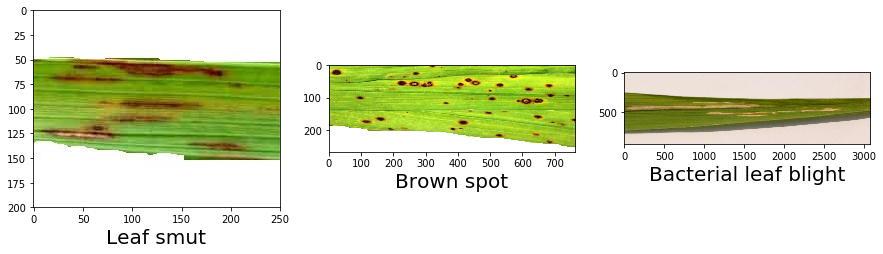

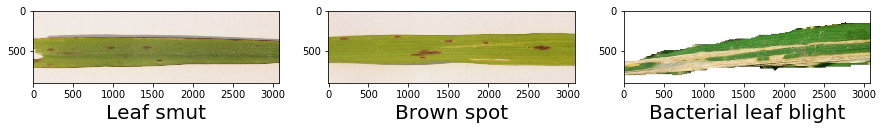

In [22]:
# set up the canvas for the subplots
plt.figure(figsize=(15,15))

# Image 1
plt.subplot(1,3,1)   # 1 row and 3 columns
item = 'DSC_0512.jpg'
path = '../input/rice-leaf-diseases/rice_leaf_diseases/Leaf smut/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Leaf smut', fontsize=20)

# Image 2
plt.subplot(1,3,2)   # 1 row and 3 columns
item = 'DSC_0108.jpg'
path = '../input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Brown spot', fontsize=20)

# Image 2
plt.subplot(1,3,3)   # 1 row and 3 columns
item = 'DSC_0402.JPG'
path = '../input/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Bacterial leaf blight', fontsize=20)






# set up the canvas for the subplots
plt.figure(figsize=(15,15))

# Image 1
plt.subplot(1,3,1)   # 1 row and 3 columns
item = 'DSC_0316.JPG'
path = '../input/rice-leaf-diseases/rice_leaf_diseases/Leaf smut/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Leaf smut', fontsize=20)

# Image 2
plt.subplot(1,3,2)   # 1 row and 3 columns
item = 'DSC_0303.JPG'
path = '../input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Brown spot', fontsize=20)

# Image 2
plt.subplot(1,3,3)   # 1 row and 3 columns
item = 'DSC_0702.jpg'
path = '../input/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Bacterial leaf blight', fontsize=20)

plt.show()

## Set up and test the Augmentations

In [23]:
# Pneumothorax - 1st place solution
# Source: https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/discussion/107824#latest-620521

# Albumentations

import albumentations as albu


def augment_image(augmentation, image):
    
    """
    Uses the Albumentations library.
    
    Inputs: 
    1. augmentation - this is the instance of type of augmentation to do 
    e.g. aug_type = HorizontalFlip(p=1) 
    # p=1 is the probability of the transform being executed.
    
    2. image - image with shape (h,w)
    
    Output:
    Augmented image as a numpy array.
    
    """
    # get the transform as a dict
    aug_image_dict =  augmentation(image=image)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']
    
    
    return image_matrix



In [24]:
# Define the transforms


aug_types = albu.Compose([
            albu.HorizontalFlip(),
             albu.OneOf([
                albu.HorizontalFlip(),
                albu.VerticalFlip(),
                ], p=0.8),
            albu.OneOf([
                albu.RandomContrast(),
                albu.RandomGamma(),
                albu.RandomBrightness(),
                ], p=0.3),
            albu.OneOf([
                albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                albu.GridDistortion(),
                albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                ], p=0.3),
            albu.ShiftScaleRotate()
            ])



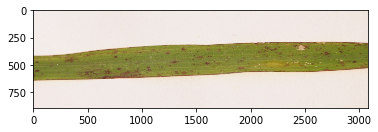

In [25]:
# Get an image to test transformations

# get a list of train png images
path = 'image_dir/'
image_list = os.listdir('image_dir')

fname = image_list[1]
image_path = path + fname

image = plt.imread(image_path)
plt.imshow(image)

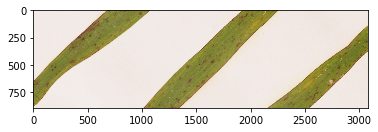

In [26]:
# Test the transformation setup.
# The image will be different each time this cell is run.

aug_image = augment_image(aug_types, image)

plt.imshow(aug_image)

## Build the Data Generators

### [ 1 ] Train Generator

In [27]:
df_train.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
15,DSC_0339.jpg,0,0,1
16,DSC_0104.jpg,0,1,0
17,DSC_0388.JPG,1,0,0
18,DSC_0500.jpg,0,0,1
19,DSC_0312.JPG,0,0,1


In [28]:
def train_generator(batch_size=8):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image'])
            
            # Create empty X matrix - 3 channels
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            
            # Create X_train
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                
            
            
            # Create y_train
            # ===============
                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_train = df[cols]
                y_train = np.asarray(y_train) 

                # change the shape to (batch_size, 1)
                #y_train = y_train.reshape((-1, 1)) # -1 tells numpy to automatically detect the batch size
       
              
            # Augment the image and mask
            # ===========================

                aug_image = augment_image(aug_types, image)
              
                # insert the image into X_train
                X_train[i] = aug_image
                
                          
                
            # Normalize the images
            X_train = X_train/255

            yield X_train, y_train

In [29]:
# Test the generator

# initialize
train_gen = train_generator(batch_size=8)

# run the generator
X_train, y_train = next(train_gen)

print(X_train.shape)
print(y_train.shape)

(8, 224, 224, 3)
(8, 3)


In [30]:
y_train

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1]])

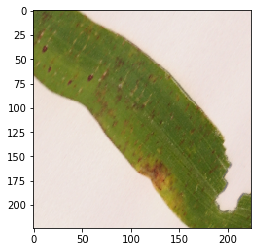

In [31]:
# Print the first image in X_train
# Remember that train images have been augmented.

image = X_train[0,:,:,:]
plt.imshow(image)

### [ 2 ] Val Generator

In [32]:
def val_generator(batch_size=5):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image'])
            
            # Create empty X matrix - 3 channels
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            
            # Create X_val
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # insert the image into X_train
                X_val[i] = image
                
                
            
            
            # Create y_val
            # ===============

                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_val = df[cols]
                y_val = np.asarray(y_val) 

                # change the shape to (batch_size, 1)
                #y_val = y_val.reshape((-1, 1)) # -1 tells numpy to automatically detect the batch size
       
            
                
                          
                
            # Normalize the images
            X_val = X_val/255

            yield X_val, y_val

In [33]:
# Test the generator

# initialize
val_gen = val_generator(batch_size=5)

# run the generator
X_val, y_val = next(val_gen)

print(X_val.shape)
print(y_val.shape)

(5, 224, 224, 3)
(5, 3)


In [34]:
y_val

array([[0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0]])

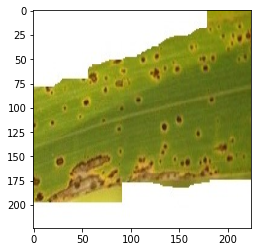

In [35]:
# print the image from X_val
image = X_val[0,:,:,:]
plt.imshow(image)

### [ 3 ] Test Generator

In [36]:
def test_generator(batch_size=1):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image'])
            
            # Create empty X matrix - 3 channels
            X_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            
            # Create X_test
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # insert the image into X_train
                X_test[i] = image
                
                 
                
            # Normalize the images
            X_test = X_test/255

            yield X_test

In [37]:
# Test the generator

# initialize
test_gen = test_generator(batch_size=1)

# run the generator
X_test = next(test_gen)

print(X_test.shape)

(1, 224, 224, 3)


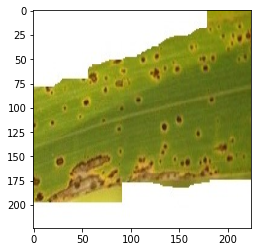

In [38]:
# print the image from X_test

image = X_test[0,:,:,:]
plt.imshow(image)

## Model Architecture

In [39]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import categorical_accuracy

from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)


In [40]:
from tensorflow.keras.applications.mobilenet import MobileNet

model = MobileNet(weights='imagenet')

# Exclude the last 2 layers of the above model.
x = model.layers[-2].output

# Create a new dense layer for predictions
# 3 corresponds to the number of classes
predictions = Dense(3, activation='softmax')(x)

# inputs=model.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=model.input, outputs=predictions)

model.summary()

Exception: URL fetch failure on https://github.com/fchollet/deep-learning-models/releases/download/v0.6/mobilenet_1_0_224_tf.h5: None -- [Errno -3] Temporary failure in name resolution

## Train the Model

In [ ]:
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 5

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = TRAIN_BATCH_SIZE
val_batch_size = VAL_BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
# Initialize the generators
train_gen = train_generator(batch_size=TRAIN_BATCH_SIZE)
val_gen = val_generator(batch_size=VAL_BATCH_SIZE)

model.compile(
    Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)



filepath = "model.h5"

#earlystopper = EarlyStopping(patience=10, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   #verbose=1, mode='min')



log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, csv_logger]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=100, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)

In [ ]:
# Display the training log

train_log = pd.read_csv('training_log.csv')

train_log.head()

## Evaluate the model on the val set

In [ ]:
# get the metric names so we can use evaulate_generator
model.metrics_names

In [ ]:
model.load_weights('model.h5')

val_gen = val_generator(batch_size=1)

val_loss, val_acc = \
model.evaluate_generator(val_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

## Plot the training curves

In [ ]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.show()

## Make a prediction on the val set

In [ ]:
test_gen = test_generator(batch_size=1)

preds = model.predict_generator(test_gen, steps=len(df_val), verbose=1)


In [ ]:
# get y_pred as index values

y_pred = np.argmax(preds, axis=1)

y_pred

In [ ]:
# get y_true as index values

cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
y_true = df_val[cols]
y_true = np.asarray(y_true) 

y_true = np.argmax(y_true, axis=1)

y_true

In [ ]:
# Compare y_true and y_pred

print(y_pred)
print(y_true)

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(y_true, y_pred)

In [ ]:
# bacterial_leaf_blight = 0
# brown_spot = 1
# leaf_smut = 2

cm_plot_labels = ['leaf_blight', 'brown_spot', 'leaf_smut']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

## Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=['bacterial_leaf_blight', 'brown_spot', 'leaf_smut'])

print(report)

**Recall** = Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

## Convert the Model to Tensorflow.js

In [ ]:
# --ignore-installed is added to fix an error.

# https://stackoverflow.com/questions/49932759/pip-10-and-apt-how-to-avoid-cannot-uninstall
# -x-errors-for-distutils-packages

!pip install tensorflowjs --ignore-installed

In [ ]:
# Use the command line conversion tool to convert the model

!tensorflowjs_converter --input_format keras model.h5 tfjs/model

In [ ]:
# check that the folder containing the tfjs model files has been created
!ls

In [ ]:
# Delete the test_dir directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

shutil.rmtree('image_dir')

In [ ]:
!ls

## Citations

- Prajapati HB, Shah JP, Dabhi VK. Detection and classification of rice plant diseases. Intelligent Decision Technologies. 2017 Jan 1;11(3):357-73, doi: 10.3233/IDT-170301.

- Ref Paper:<br>
Detection and classification of rice plant diseases
https://www.researchgate.net/publication/318437440_Detection_and_classification_of_rice_plant_diseases

- Header image by HoangTuan_photography on Pixabay


## Helpful Resources

- Albumentations paper:<br>
Albumentations: fast and flexible image augmentations<br>
https://arxiv.org/abs/1809.06839

- If you would like to learn how to build Tensorflow.js web apps I recommend this video tutorial:<br>
https://www.youtube.com/watch?v=HEQDRWMK6yY

- I've also included a few practical app implementation tips on the readme page in this repo:<br>
https://github.com/vbookshelf/Skin-Lesion-Analyzer

## Conclusion

Here are a few things you could try:
- Implement 10 fold cross validation.
- Use a different pre-trained model e.g. Densenet169 or Resnet18.
- Use different image pre-processing methods.
- Use a different augmentation setup or none at all.

Thank you for reading.